## Introduction

In this IBM Data Science Capstone Project, we will go through extracting various data tables on web portals using Pandas & BeautifulSoup Libraries and joining them. We also convert addresses into their equivalent latitude and longitude values. 
Then, we will use the Foursquare API to explore neighborhoods in London, United Kingdom. We will use the **explore** function to get the most common venue categories in each Postcodes in question, and then use this feature to group them into clusters. We will use the *k*-means clustering algorithm to complete this project. Finally, We will use the Folium library to visualize the locations in London and their emerging clusters.
Aim: The goal is to gauge if it’s feasible to achieve a balance between affordability (House prices), great primary education for children (Outstanding State Schools within proximity) and likeliness towards an area kind.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [79]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install BeautifulSoup4

import csv

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install lxml

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


## 1. Download and Explore Dataset

We will need to extract below dataset, wrangle and combine them to make it work for the goal, we are trying to achieve.

1. London has more than 2300 Primary Schools. Such detals are available Its available on Government web: https://reports.ofsted.gov.uk
2. List of London Areas: We will need to get London areas to expand on the School data. This is available on wikipedia: https://en.wikipedia.org/wiki/List_of_areas_of_London
3. Property prices at a Postcode level: https://propertydata.co.uk/cities/london

### 1st Table: Lets first extract School data. Since the data is not available in table format, we will be using BeautifulSoup library to extract html data

In [160]:
from bs4 import BeautifulSoup
url = 'https://reports.ofsted.gov.uk/search?q=&location=&radius=&level_2_types%5B%5D=1&latest_report_date_start=&latest_report_date_end=&region%5B%5D=E12000007&status%5B%5D=1&level_1_types=1'
source = requests.get(url).text
Soup = BeautifulSoup(source, 'lxml')
# print(Soup.prettify())

School_Details = Soup.find('li', class_='search-result')
#print(MainTest.prettify())

Name = School_Details.h3.a.text
print(Name)
Address = School_Details.address.text
print(Address)
Rating = School_Details.strong.text
print(Rating)
URN = School_Details.find_all('li')[0].text.split(': ')[1]
print(URN)
Type = School_Details.find_all('li')[1].text.split(': ')[1]
print(Type)
Latest_Report = School_Details.time.text
print(Latest_Report)


Abacus Belsize Primary School
Jubilee Waterside Centre, 105 Camley Street, London, N1C 4PF
Outstanding
139837
Primary
09 June 2015


As a sanity check, lets see Ratings of all Schools on first page of the results on website 

In [161]:
url = 'https://reports.ofsted.gov.uk/search?q=&location=&radius=&level_2_types%5B%5D=1&latest_report_date_start=&latest_report_date_end=&region%5B%5D=E12000007&status%5B%5D=1&level_1_types=1'
source = requests.get(url).text
Soup = BeautifulSoup(source, 'lxml')
# print(Soup.prettify())

for School_Details in Soup.find_all('li', class_='search-result'):
    try:
        Name = School_Details.h3.a.text
        Address = School_Details.address.text
        Rating = School_Details.strong.text
        URN = School_Details.find_all('li')[0].text.split(': ')[1]
        Type = School_Details.find_all('li')[1].text.split(': ')[1]
        Latest_Report = School_Details.time.text
    except:
        Name = School_Details.h3.a.text
        Address = School_Details.address.text
        Rating = None
        URN = School_Details.find_all('li')[0].text.split(': ')[1]
        Type = School_Details.find_all('li')[1].text.split(': ')[1]
        Latest_Report = School_Details.time.text

    print(Rating)


Outstanding
Good
None
Good
Good
Good
Requires Improvement
Good
Good
Good


We use the below cell to extract all the data and convert it into a csv file

In [162]:
csv_file = open('London_Schools_Scrape.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Name', 'Address', 'Rating', 'URN', 'Type', 'Latest_Report'])

for i in range(239):
    url= 'https://reports.ofsted.gov.uk/search?q=&location=&radius=&level_2_types%5B0%5D=1&region%5B0%5D=E12000007&status%5B0%5D=1&level_1_types=1&start={}0&rows=10'.format(i)
    source = requests.get(url).text
    Soup = BeautifulSoup(source, 'lxml')
    # print(Soup.prettify())

    for School_Details in Soup.find_all('li', class_='search-result'):
        try:
            Name = School_Details.h3.a.text
        except:
            Name = "Not Available"
        try:
            Address = School_Details.address.text
        except:
            Address = "Not Available"
        try:
            Rating = School_Details.strong.text
        except:
            Rating = "Not Available"
        try:
            URN = School_Details.find_all('li')[0].text.split(': ')[1]
        except:
            URN = "Not Available"
        try:
            Type = School_Details.find_all('li')[1].text.split(': ')[1]
        except:
            Type = "Not Available"
        try:
            Latest_Report = School_Details.time.text
        except:
            Latest_Report = "Not Available"

        csv_writer.writerow([Name, Address, Rating, URN, Type, Latest_Report])
        
        #print(Name)
        
csv_file.close()

Lets reas the csv file into Pandas Dataframe

In [163]:
School_data = pd.read_csv('London_Schools_Scrape.csv')
School_data.head()

,Name,Address,Rating,URN,Type,Latest_Report
0,Abacus Belsize Primary School,"Jubilee Waterside Centre, 105 Camley Street, L...",Outstanding,139837,Primary,09 June 2015
1,Abbey Manor College,"40 Falmouth Close, London, SE12 8JP",Good,130856,Pupil Referral Unit,08 July 2016
2,Abbey Primary School,"Glastonbury Road, Morden, Surrey, SM4 6NY",Not Available,146160,Primary,12 September 2018
3,Abbotsbury Primary School,"Abbotsbury Road, Morden, Surrey, SM4 5JS",Good,102649,Primary,21 November 2017
4,Adamsrill Primary School,"Adamsrill Road, Sydenham, London, SE26 4AQ",Good,100671,Primary,07 February 2020


As we noticed above that some of the field shows "Not Available", lets convert those to NaN which will help dealing with it easily later

In [164]:
School_data.replace("Not Available", np.nan, inplace = True)
School_data.head(5)

,Name,Address,Rating,URN,Type,Latest_Report
0,Abacus Belsize Primary School,"Jubilee Waterside Centre, 105 Camley Street, L...",Outstanding,139837,Primary,09 June 2015
1,Abbey Manor College,"40 Falmouth Close, London, SE12 8JP",Good,130856,Pupil Referral Unit,08 July 2016
2,Abbey Primary School,"Glastonbury Road, Morden, Surrey, SM4 6NY",NaN,146160,Primary,12 September 2018
3,Abbotsbury Primary School,"Abbotsbury Road, Morden, Surrey, SM4 5JS",Good,102649,Primary,21 November 2017
4,Adamsrill Primary School,"Adamsrill Road, Sydenham, London, SE26 4AQ",Good,100671,Primary,07 February 2020


Let's try to explore how many missing values we may have

In [165]:
missing_data = School_data.isnull()
missing_data.head(20)

,Name,Address,Rating,URN,Type,Latest_Report
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,True,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False
7,False,False,False,False,False,False
8,False,False,False,False,False,False
9,False,False,False,False,False,False


In [166]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    

Name
False    2375
Name: Name, dtype: int64

Address
False    2375
Name: Address, dtype: int64

Rating
False    2084
True      291
Name: Rating, dtype: int64

URN
False    2333
True       42
Name: URN, dtype: int64

Type
False    2333
True       42
Name: Type, dtype: int64

Latest_Report
False    2333
True       42
Name: Latest_Report, dtype: int64



In [167]:
School_data.count()

Name             2375
Address          2375
Rating           2084
URN              2333
Type             2333
Latest_Report    2333
dtype: int64

We dont need URN column so lets delete it

In [168]:
School_data = School_data.drop(columns='URN')

In [169]:
School_data.head()

,Name,Address,Rating,Type,Latest_Report
0,Abacus Belsize Primary School,"Jubilee Waterside Centre, 105 Camley Street, L...",Outstanding,Primary,09 June 2015
1,Abbey Manor College,"40 Falmouth Close, London, SE12 8JP",Good,Pupil Referral Unit,08 July 2016
2,Abbey Primary School,"Glastonbury Road, Morden, Surrey, SM4 6NY",NaN,Primary,12 September 2018
3,Abbotsbury Primary School,"Abbotsbury Road, Morden, Surrey, SM4 5JS",Good,Primary,21 November 2017
4,Adamsrill Primary School,"Adamsrill Road, Sydenham, London, SE26 4AQ",Good,Primary,07 February 2020


Being conservative, we would like to avoid any school into our dataset with missing info, thus lets delete any such rows

In [170]:
School_data2 = School_data.mask(School_data.eq('Not Available')).dropna()

In [171]:
print(School_data2.count())

Name             2043
Address          2043
Rating           2043
Type             2043
Latest_Report    2043
dtype: int64


In [172]:
School_data2['Type'].unique().tolist()

['Primary',
 'Pupil Referral Unit',
 'Independent School',
 'Other schools',
 'Special School']

Let's explore how many schools exist under each Rating type

In [173]:
print(School_data2["Rating"].value_counts())
print(School_data2.groupby('Rating').nunique())

Good                    1352
Outstanding              531
Requires Improvement     119
Inadequate                39
Satisfactory               2
Name: Rating, dtype: int64
                      Name  Address  Rating  Type  Latest_Report
Rating                                                          
Good                  1299     1318       1     5            604
Inadequate              39       39       1     3             36
Outstanding            519      524       1     5            406
Requires Improvement   119      119       1     5            104
Satisfactory             2        2       1     1              2


##### This step is very important. Since we will only be able to compare and join tables based on first 3 letters of a postcode, we will apply a code to extract such information from School Address and create another column

In [174]:
School_data2['PostCode'] = School_data2.Address.str.split(',').apply(lambda x: x[-1]).str.split().apply(lambda x: x[0])

In [175]:
print(School_data2.Name.count())
School_data2.head()

2043


,Name,Address,Rating,Type,Latest_Report,PostCode
0,Abacus Belsize Primary School,"Jubilee Waterside Centre, 105 Camley Street, L...",Outstanding,Primary,09 June 2015,N1C
1,Abbey Manor College,"40 Falmouth Close, London, SE12 8JP",Good,Pupil Referral Unit,08 July 2016,SE12
3,Abbotsbury Primary School,"Abbotsbury Road, Morden, Surrey, SM4 5JS",Good,Primary,21 November 2017,SM4
4,Adamsrill Primary School,"Adamsrill Road, Sydenham, London, SE26 4AQ",Good,Primary,07 February 2020,SE26
5,Addison Primary School,"Addison Gardens, Blythe Road, London, W14 0DT",Good,Primary,12 September 2016,W14


Again being conservative, we would only consider schools that had been assessed as Outstanding only in recent years because assessments done prior to that may still not hold. We will also ignore fields not relevant for further analysis

In [176]:
search_values = ['2018','2019', '2020']
School_Details = School_data2[School_data2['Latest_Report'].str.contains('|'.join(search_values ))].reset_index(drop=True)
print('No. of Schools that had assessment in 2018, 2019 or 2020: ', School_Details.Name.count())

School_Primary = School_Details[School_Details.Type == 'Primary'].reset_index(drop=True)
print('ONLY Primary Schools out of those: ', School_Primary.Name.count())

School_PrimOuts = School_Primary[School_Primary.Rating == 'Outstanding'].reset_index(drop=True)
print('ONLY Outstanding Schools out of those: ', School_PrimOuts.Name.count())

School_PrimOuts = School_PrimOuts.drop(columns=['Address', 'Latest_Report'])
#School_PrimOuts.head()

School_PrimOuts = School_PrimOuts.groupby(['PostCode', 'Rating', 'Type']).agg({'Name': ",".join}).reset_index()

print('Grouping by PostCode: ', School_PrimOuts.Name.count())
School_PrimOuts.head()

No. of Schools that had assessment in 2018, 2019 or 2020:  1116
ONLY Primary Schools out of those:  771
ONLY Outstanding Schools out of those:  75
Grouping by PostCode:  62


,PostCode,Rating,Type,Name
0,BR1,Outstanding,Primary,Burnt Ash Primary School
1,BR3,Outstanding,Primary,"Clare House Primary School,Harris Primary Acad..."
2,BR5,Outstanding,Primary,Crofton Junior School
3,CR0,Outstanding,Primary,"Chestnut Park Primary School,Harris Primary Ac..."
4,CR5,Outstanding,Primary,Woodcote Primary School


### 2nd Table: Lets now extract the table from wikipedia showing all areas of London by Postcode, Borough, Loction and Town. We will read html data using Pandas 

In [177]:
from pandas.io.html import read_html
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
London_Areas = pd.read_html(url, header=0)[1]
London_Areas.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


#### As we see above, there are many anomalies in the data like (1) London Borough field has squared brackets; (2) Postcode district has multiple postcodes within same row; (3) Last 2 columns are not relevant at all. We will fix them all below

In [178]:
London_Areas.columns

Index(['Location', 'London borough', 'Post town', 'Postcode district',
       'Dial code', 'OS grid ref'],
      dtype='object')

Let's change the column names to align with other table

In [179]:
London_Areas.columns = ['Location','Borough','Postal_Town','PostCode','Dial Code','OS Grid Ref']
print('No. of Line Items: ', London_Areas.Location.count())
London_Areas.head()

No. of Line Items:  533


,Location,Borough,Postal_Town,PostCode,Dial Code,OS Grid Ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


We have to create multiple lines for multiple postcodes within same row

In [180]:
London_Areas = London_Areas.set_index(['Location', 'Borough', 'Postal_Town', 'Dial Code', 'OS Grid Ref']).PostCode.str.split(',', expand=True).stack().reset_index(['Location', 'Borough', 'Postal_Town', 'Dial Code', 'OS Grid Ref'])
London_Areas.head()

,Location,Borough,Postal_Town,Dial Code,OS Grid Ref,0
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,020,TQ465785,SE2
0,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,020,TQ205805,W4
0,Addington,Croydon[8],CROYDON,020,TQ375645,CR0
0,Addiscombe,Croydon[8],CROYDON,020,TQ345665,CR0


In [181]:
London_Areas.reset_index(inplace = True, drop = True) 
London_Areas.head()

,Location,Borough,Postal_Town,Dial Code,OS Grid Ref,0
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,020,TQ205805,W3
2,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,020,TQ205805,W4
3,Addington,Croydon[8],CROYDON,020,TQ375645,CR0
4,Addiscombe,Croydon[8],CROYDON,020,TQ345665,CR0


In [182]:
London_Areas.columns = ['Location','Borough','Postal_Town','Dial Code','OS Grid Ref', 'PostCode']
London_Areas.head()

,Location,Borough,Postal_Town,Dial Code,OS Grid Ref,PostCode
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,020,TQ205805,W3
2,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,020,TQ205805,W4
3,Addington,Croydon[8],CROYDON,020,TQ375645,CR0
4,Addiscombe,Croydon[8],CROYDON,020,TQ345665,CR0


Let's fix the Borough columns to remove square brackets

In [183]:
London_Areas['Borough'] =  London_Areas['Borough'].apply(lambda x: x.replace('[','').replace(']','')) 
London_Areas['Borough'] =  London_Areas['Borough'].str.replace('\d+', '')
London_Areas['Borough'] =  London_Areas['Borough'].str.split(',').str[0]
#London_Areas['PostCode'] =  London_Areas['PostCode'].str.split('(').str[0]
#London_Areas['PostCode'] =  London_Areas['PostCode'].str.split(')').str[1]
London_Areas['Postal_Town'] =  London_Areas['Postal_Town'].str.split(',').str[0]
London_Areas.head()

,Location,Borough,Postal_Town,Dial Code,OS Grid Ref,PostCode
0,Abbey Wood,Bexley,LONDON,020,TQ465785,SE2
1,Acton,Ealing,LONDON,020,TQ205805,W3
2,Acton,Ealing,LONDON,020,TQ205805,W4
3,Addington,Croydon,CROYDON,020,TQ375645,CR0
4,Addiscombe,Croydon,CROYDON,020,TQ345665,CR0


Let's group all the rows by PostCodes (as thats what we need to use to combine other tables or London areas) for further analysis. That will combine Location and Boroughs within one rows separates by commas and /

In [184]:
London_Areas['PostCode'] =  London_Areas['PostCode'].str.replace(' ', '')
London_Areas = London_Areas.groupby(['PostCode', 'Borough']).agg({'Location': ",".join}).reset_index()
London_Areas = London_Areas.groupby(['PostCode']).agg({'Location': ",".join, 'Borough': "/".join}).reset_index() 
#London_Areas['Postal_Town'] =  London_Areas['Postal_Town'].str.split(',').str[0]
#London_Areas = London_Areas.groupby(['PostCode', 'Location']).agg({'Borough': ",".join}).reset_index()
London_Areas.head()

,PostCode,Location,Borough
0,BR1,"Bromley,Plaistow,Sundridge,Widmore (also Widmo...",Bromley/Lewisham
1,BR2,"Hayes,Keston,Leaves Green,Southborough",Bromley
2,BR3,"Beckenham,Bickley,Bromley Common,Eden Park,Elm...",Bromley
3,BR4,"Coney Hall,West Wickham",Bromley
4,BR5,"Ruxley,Upper Ruxley,Derry Downs,Orpington,Pett...",Bexley/Bromley


###Let's join both the tables and see first 20 rows to get an idea if everything looks fine

In [185]:
PrimOutsAreas_merged = School_PrimOuts.join(London_Areas.set_index('PostCode'), on='PostCode')
PrimOutsAreas_merged.head(20)

,PostCode,Rating,Type,Name,Location,Borough
0,BR1,Outstanding,Primary,Burnt Ash Primary School,"Bromley,Plaistow,Sundridge,Widmore (also Widmo...",Bromley/Lewisham
1,BR3,Outstanding,Primary,"Clare House Primary School,Harris Primary Acad...","Beckenham,Bickley,Bromley Common,Eden Park,Elm...",Bromley
2,BR5,Outstanding,Primary,Crofton Junior School,"Ruxley,Upper Ruxley,Derry Downs,Orpington,Pett...",Bexley/Bromley
3,CR0,Outstanding,Primary,"Chestnut Park Primary School,Harris Primary Ac...","Addington,Addiscombe,Coombe,Croydon,Forestdale...",Croydon/Sutton
4,CR5,Outstanding,Primary,Woodcote Primary School,"Coulsdon,Old Coulsdon",Croydon
5,CR7,Outstanding,Primary,David Livingstone Academy,Thornton Heath,Croydon
6,CR8,Outstanding,Primary,Beaumont Primary School,"Kenley,Purley,Riddlesdown",Croydon
7,DA15,Outstanding,Primary,Burnt Oak Junior School,"Blackfen,Lamorbey,Longlands,Sidcup",Bexley
8,DA16,Outstanding,Primary,Eastcote Primary Academy,"East Wickham,Falconwood,Welling",Bexley
9,E12,Outstanding,Primary,Essex Primary School,"Little Ilford,Manor Park",Newham


We noticed that some of rows above have NaN values so lets take a look if there are more

In [186]:
PrimOutsAreas_merged[PrimOutsAreas_merged.isna().any(axis=1)]

,PostCode,Rating,Type,Name,Location,Borough
14,E1W,Outstanding,Primary,St Peter's London Docks CofE Primary School,NaN,NaN
19,EC1V,Outstanding,Primary,"City of London Primary Academy, Islington",NaN,NaN
51,SW1W,Outstanding,Primary,St Peter's Eaton Square CofE Primary School,NaN,NaN


With further analysis we figured out that the postcodes are not in correct format for 3 rows above. We need to remove last alphabets from these which we do in cell below

In [187]:
#import string
#PrimOutsAreas_merged = PrimOutsAreas_merged['PostCode'].str.rstrip(string.ascii_letters + string.whitespace)
#PrimOutsAreas_merged['PostCode'] =  PrimOutsAreas_merged(PrimOutsAreas_merged['PostCode'][-1]).str.replace('\D', '')
#if PrimOutsAreas_merged('PostCode')[-1] in string.ascii_letters:
 #   PrimOutsAreas_merged('PostCode') = PrimOutsAreas_merged('PostCode')[0:-1].strip()
#London_Areas['Borough'] =  London_Areas['Borough'].apply(lambda x: x.replace('[','').replace(']','')) 
School_PrimOuts['PostCode'] =  School_PrimOuts['PostCode'].map(lambda x: x.rstrip('WV'))
#bulb_temp_df['A'].map(lambda x: x.rstrip('aAbBcC'))
                                                                           
                                                                          # replace('[','').replace(']','')) 
School_PrimOuts.head(20)

,PostCode,Rating,Type,Name
0,BR1,Outstanding,Primary,Burnt Ash Primary School
1,BR3,Outstanding,Primary,"Clare House Primary School,Harris Primary Acad..."
2,BR5,Outstanding,Primary,Crofton Junior School
3,CR0,Outstanding,Primary,"Chestnut Park Primary School,Harris Primary Ac..."
4,CR5,Outstanding,Primary,Woodcote Primary School
5,CR7,Outstanding,Primary,David Livingstone Academy
6,CR8,Outstanding,Primary,Beaumont Primary School
7,DA15,Outstanding,Primary,Burnt Oak Junior School
8,DA16,Outstanding,Primary,Eastcote Primary Academy
9,E12,Outstanding,Primary,Essex Primary School


In [188]:
PrimOutsAreas_merged = School_PrimOuts.join(London_Areas.set_index('PostCode'), on='PostCode')
PrimOutsAreas_merged.head()

,PostCode,Rating,Type,Name,Location,Borough
0,BR1,Outstanding,Primary,Burnt Ash Primary School,"Bromley,Plaistow,Sundridge,Widmore (also Widmo...",Bromley/Lewisham
1,BR3,Outstanding,Primary,"Clare House Primary School,Harris Primary Acad...","Beckenham,Bickley,Bromley Common,Eden Park,Elm...",Bromley
2,BR5,Outstanding,Primary,Crofton Junior School,"Ruxley,Upper Ruxley,Derry Downs,Orpington,Pett...",Bexley/Bromley
3,CR0,Outstanding,Primary,"Chestnut Park Primary School,Harris Primary Ac...","Addington,Addiscombe,Coombe,Croydon,Forestdale...",Croydon/Sutton
4,CR5,Outstanding,Primary,Woodcote Primary School,"Coulsdon,Old Coulsdon",Croydon


In [189]:
PrimOutsAreas_merged[PrimOutsAreas_merged.isna().any(axis=1)]

,PostCode,Rating,Type,Name,Location,Borough


### 3rd Table: Let's now extract the table from Property portal to get average house prices for each Postcode

In [190]:
Prop_Prices = pd.read_html("https://propertydata.co.uk/cities/london",header=0)[0]
Prop_Prices.head()

,Area,Avg yield,Avg price,£/sqft,5yr +/-,Explore data
0,BR1,3.6%,"£448,102",£463,+25%,Explore data
1,BR2,3.1%,"£514,220",£469,+27%,Explore data
2,BR3,3.7%,"£450,943",£489,+26%,Explore data
3,BR5,3.7%,"£440,106",£426,+26%,Explore data
4,BR6,3.1%,"£558,041",£464,+25%,Explore data


Remove all redundant columns

In [191]:
Prop_Prices.drop(columns=['Avg yield','£/sqft','5yr +/-','Explore data'], inplace=True)

In [192]:
Prop_Prices.head()

,Area,Avg price
0,BR1,"£448,102"
1,BR2,"£514,220"
2,BR3,"£450,943"
3,BR5,"£440,106"
4,BR6,"£558,041"


Let's remove commas and £ sign from values to convert column into integer type

In [193]:
Prop_Prices['Avg price'] = Prop_Prices['Avg price'].str.replace("£","")
Prop_Prices['Avg price'] = Prop_Prices['Avg price'].str.replace(',', '')
Prop_Prices['Avg price'] = pd.to_numeric(Prop_Prices['Avg price'])

In [194]:
Prop_Prices = Prop_Prices.rename({'Area':'PostCode'}, axis=1)
Prop_Prices.head()

,PostCode,Avg price
0,BR1,448102
1,BR2,514220
2,BR3,450943
3,BR5,440106
4,BR6,558041


In [195]:
Prop_Prices.dtypes

PostCode     object
Avg price     int64
dtype: object

In [196]:
Prop_Prices.to_csv('london_Prop_Prices.csv',index=False)

### Since the values of houses in the catchment of Outstanding Schools can be at premium of 10-20%, we will increase the prices by 20% being conservative here

In [197]:
Prop_Prices['Avg price'] = Prop_Prices['Avg price']*1.2
Prop_Prices.head()

,PostCode,Avg price
0,BR1,537722.4
1,BR2,617064.0
2,BR3,541131.6
3,BR5,528127.2
4,BR6,669649.2


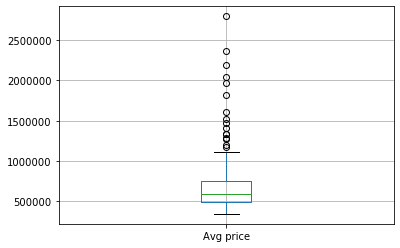

In [198]:
Prop_Prices.boxplot(column='Avg price')

#### Let's now merge all 3 tables by Postcodes

In [199]:
PrimOutsAreas_merged = PrimOutsAreas_merged.join(Prop_Prices.set_index('PostCode'), on='PostCode')
PrimOutsAreas_merged.head()

,PostCode,Rating,Type,Name,Location,Borough,Avg price
0,BR1,Outstanding,Primary,Burnt Ash Primary School,"Bromley,Plaistow,Sundridge,Widmore (also Widmo...",Bromley/Lewisham,537722.4
1,BR3,Outstanding,Primary,"Clare House Primary School,Harris Primary Acad...","Beckenham,Bickley,Bromley Common,Eden Park,Elm...",Bromley,541131.6
2,BR5,Outstanding,Primary,Crofton Junior School,"Ruxley,Upper Ruxley,Derry Downs,Orpington,Pett...",Bexley/Bromley,528127.2
3,CR0,Outstanding,Primary,"Chestnut Park Primary School,Harris Primary Ac...","Addington,Addiscombe,Coombe,Croydon,Forestdale...",Croydon/Sutton,414672.0
4,CR5,Outstanding,Primary,Woodcote Primary School,"Coulsdon,Old Coulsdon",Croydon,611338.8


#### Now we need the coordinates of these locations to explore venues nearby thus in order to get latitudes and longitudes, lets install geocoder

In [200]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


Now, we will define a function to get location coordinates which we will use to extract for all the postcodes in final table above

In [201]:
import geocoder
def getLatLong(row):
    # initialize your variable to None
    lat_lng_coords = None
    search_query = '{}, United Kingdom'.format(row)
    # loop until you get the coordinates
    try:
        while(lat_lng_coords is None):
            #g = geocoder.here(search_query,app_id=app_id,app_code=app_code)
            g = geocoder.arcgis(search_query, components="country:GB")
            lat_lng_coords = g.latlng
            #print('FIRST')
    except IndexError:
        latitude = 0.0
        longitude = 0.0
        print('BACKUP')
        return [latitude,longitude]

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    print(latitude, longitude)
    return [latitude, longitude]

In [202]:
coords_list = PrimOutsAreas_merged['PostCode'].apply(getLatLong).tolist()
#coords_list = getLatLong(PrimOutsAreas_merged['PostCode']).tolist()

51.404240403000074 0.015425000000050204
51.415095000000065 -0.035402759999954014
51.388315000000034 0.07848166000002266
51.34497991500007 -0.012264999999956672
51.30016500000005 -0.12369758499994532
51.39566257900003 -0.11944499999992786
51.33327500000007 -0.10238103799997589
51.463130000000035 0.231270061000032
51.46897716700005 0.11798500000003287
51.51447652300004 -0.058604999999943175
51.51782500000007 -0.04849044199994523
51.52238500000004 -0.04583075199997211
51.52080500000005 -0.06353187499996693
51.51655500000004 -0.07349107599992522
51.52022000000005 -0.054309999999929914
51.52669000000003 -0.06256999999993695
51.558970000000045 -0.05322999999992817
51.53292000000005 0.05461000000002514
51.54505000000006 -0.05531999999993786
51.523610000000076 -0.09876999999994496
51.536910000000034 -0.29731814899997744
51.58595865700005 -0.3384599999999409
51.56029500000005 -0.39388279099995316
51.55760500000008 0.0825588280000602
51.58222800000004 0.04941802500002268
51.42285500000003 -0.292

Let's add the coordinates above into our dataframe

In [203]:
PrimOutsAreas_merged[['Latitude','Longitude']] = pd.DataFrame(coords_list,columns=['Latitude', 'Longitude'])
PrimOutsAreas_merged.head()

,PostCode,Rating,Type,Name,Location,Borough,Avg price,Latitude,Longitude
0,BR1,Outstanding,Primary,Burnt Ash Primary School,"Bromley,Plaistow,Sundridge,Widmore (also Widmo...",Bromley/Lewisham,537722.4,51.404240,0.015425
1,BR3,Outstanding,Primary,"Clare House Primary School,Harris Primary Acad...","Beckenham,Bickley,Bromley Common,Eden Park,Elm...",Bromley,541131.6,51.415095,-0.035403
2,BR5,Outstanding,Primary,Crofton Junior School,"Ruxley,Upper Ruxley,Derry Downs,Orpington,Pett...",Bexley/Bromley,528127.2,51.388315,0.078482
3,CR0,Outstanding,Primary,"Chestnut Park Primary School,Harris Primary Ac...","Addington,Addiscombe,Coombe,Croydon,Forestdale...",Croydon/Sutton,414672.0,51.344980,-0.012265
4,CR5,Outstanding,Primary,Woodcote Primary School,"Coulsdon,Old Coulsdon",Croydon,611338.8,51.300165,-0.123698


Now, we will visualise these locations on a map so let's first get the coordinates of London, UK

In [204]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="London_Schools")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))
print(Nominatim(user_agent="Toronto_explorer"))
print(geolocator.geocode(address))

The geograpical coordinate of Toronto City are 51.5073219, -0.1276474.
London, Greater London, England, SW1A 2DX, United Kingdom


In [205]:
# create map of toronto using latitude and longitude values
map_London = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, location, borough in zip(PrimOutsAreas_merged['Latitude'], PrimOutsAreas_merged['Longitude'], PrimOutsAreas_merged['Location'], PrimOutsAreas_merged['Borough']):
    label = '{}, {}'.format(location, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_London)  
    
map_London

#### Define Foursquare Credentials and Version

In [206]:
CLIENT_ID = 'KQXUYFYPXLQRRKONLV5OWNWLWPFAOOSHVL0HUMZU2KKRNXXU' #  Foursquare ID
CLIENT_SECRET = 'HWICFNRCOQNKVVBTVLLKHO3KWLEPYG0U0ZLCVPWKV3NYEU4U' #  Foursquare Secret
VERSION = '20200302' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KQXUYFYPXLQRRKONLV5OWNWLWPFAOOSHVL0HUMZU2KKRNXXU
CLIENT_SECRET:HWICFNRCOQNKVVBTVLLKHO3KWLEPYG0U0ZLCVPWKV3NYEU4U


#### Let's explore the first Outstanding School (or set of outstanding schools within same PostCode)  in our dataframe.

In [207]:
PrimOutsAreas_merged.loc[0, 'Name']

'Burnt Ash Primary School'

Get the School's latitude and longitude values.

In [208]:
School_latitude = PrimOutsAreas_merged.loc[0, 'Latitude'] # School latitude value
School_longitude = PrimOutsAreas_merged.loc[0, 'Longitude'] # School longitude value

School_PostCode = PrimOutsAreas_merged.loc[0, 'PostCode'] # School Postcode
School_name = PrimOutsAreas_merged.loc[0, 'Name'] # School name

print('Latitude and longitude values of {}, {} are {}, {}.'.format(School_name, 
                                                               School_PostCode,
                                                               School_latitude, 
                                                               School_longitude))

Latitude and longitude values of Burnt Ash Primary School, BR1 are 51.404240403000074, 0.015425000000050204.


#### Now, let's get the top 100 venues that are within a radius of 500 meters of School's PostCode.

In [209]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    School_latitude, 
    School_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=KQXUYFYPXLQRRKONLV5OWNWLWPFAOOSHVL0HUMZU2KKRNXXU&client_secret=HWICFNRCOQNKVVBTVLLKHO3KWLEPYG0U0ZLCVPWKV3NYEU4U&v=20200302&ll=51.404240403000074,0.015425000000050204&radius=1000&limit=100'

Let's Send the GET request and examine the resutls

In [210]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e63b13260ba0800285df5b3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bromley Town',
  'headerFullLocation': 'Bromley Town, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 56,
  'suggestedBounds': {'ne': {'lat': 51.413240412000086,
    'lng': 0.029825275198514866},
   'sw': {'lat': 51.39524039400006, 'lng': 0.0010247248015855422}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ecd6c670aafd1868b867683',
       'name': 'Barrel & Horn',
       'location': {'address': '204-206 High Street',
        'lat': 51.40588697867192,
        'lng': 0.013701243249897743,
        'labeledLatLngs': [{'label': 'display',
       

All the information is in the *items* key. Let's define the **get_category_type** function

In [211]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [212]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


nearby_venues.head()

,name,categories,lat,lng
0,Barrel & Horn,Bar,51.405887,0.013701
1,unico,Ice Cream Shop,51.402189,0.015725
2,Apple Bromley,Electronics Store,51.402940,0.016252
3,Marks & Spencer,Department Store,51.404017,0.015718
4,Bromley Picturehouse,Indie Movie Theater,51.406740,0.012303


In [213]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

56 venues were returned by Foursquare.


#### Explore all Outstanding Primary Schools in London (i.e. PrimOutsAreas_merged Dataframe)

#### Let's create a function to repeat the same process to all the Schools

In [214]:
def getNearbyVenues(postcodes, schools, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for postcode, school, lat, lng in zip(postcodes, schools, latitudes, longitudes):
        print(school)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postcode,
            school, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostCode',
                  'School(s)',
                  'PostCode Latitude', 
                  'PostCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now try the code to run the above function on each School and create a new dataframe called *London_PrimOutsSchlVens*.

In [215]:
London_PrimOutsSchlVenues = getNearbyVenues(postcodes=PrimOutsAreas_merged['PostCode'],
                                      schools=PrimOutsAreas_merged['Name'],
                                   latitudes=PrimOutsAreas_merged['Latitude'],
                                   longitudes=PrimOutsAreas_merged['Longitude']
                                  )

Burnt Ash Primary School
Clare House Primary School,Harris Primary Academy Beckenham
Crofton Junior School
Chestnut Park Primary School,Harris Primary Academy Purley Way,Heathfield Academy
Woodcote Primary School
David Livingstone Academy
Beaumont Primary School
Burnt Oak Junior School
Eastcote Primary Academy
Essex Primary School
Portway Primary School
St Saviour's Church of England Primary School
Mossbourne Riverside Academy
South Grove Primary School,St Saviour's Church of England Primary School
St Peter's London Docks CofE Primary School
Sebright School
Southwold Primary School
St Stephen's Primary School
Queensbridge Primary School,Shacklewell Primary School
City of London Primary Academy, Islington
East Lane Primary School
Vaughan Primary School
Sacred Heart Catholic Primary School
Cleveland Road Primary School,Highlands Primary School
Redbridge Primary School
Coombe Hill Junior School
Hackney New Primary School,Shoreditch Park Primary School
Our Lady of Muswell Catholic Primary 

#### Let's check the size of the resulting dataframe

In [216]:
print(London_PrimOutsSchlVenues.shape)
London_PrimOutsSchlVenues.head()

(3749, 8)


,PostCode,School(s),PostCode Latitude,PostCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BR1,Burnt Ash Primary School,51.40424,0.015425,Barrel & Horn,51.405887,0.013701,Bar
1,BR1,Burnt Ash Primary School,51.40424,0.015425,unico,51.402189,0.015725,Ice Cream Shop
2,BR1,Burnt Ash Primary School,51.40424,0.015425,Apple Bromley,51.402940,0.016252,Electronics Store
3,BR1,Burnt Ash Primary School,51.40424,0.015425,Marks & Spencer,51.404017,0.015718,Department Store
4,BR1,Burnt Ash Primary School,51.40424,0.015425,Bromley Picturehouse,51.406740,0.012303,Indie Movie Theater


Let's check how many venues were returned for each PostCode

In [217]:
London_PrimOutsSchlVenues.groupby('PostCode').count()

,School(s),PostCode Latitude,PostCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
PostCode,,,,,,,
BR1,56,56,56,56,56,56,56
BR3,42,42,42,42,42,42,42
BR5,16,16,16,16,16,16,16
CR0,8,8,8,8,8,8,8
CR5,4,4,4,4,4,4,4
CR7,13,13,13,13,13,13,13
CR8,9,9,9,9,9,9,9
DA15,4,4,4,4,4,4,4
DA16,15,15,15,15,15,15,15


#### Let's find out how many unique categories can be curated from all the returned venues

In [218]:
print('There are {} uniques categories.'.format(len(London_PrimOutsSchlVenues['Venue Category'].unique())))

There are 293 uniques categories.


## Analyze Each PostCode's venue categories

In [219]:
# one hot encoding
London_onehot = pd.get_dummies(London_PrimOutsSchlVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['PostCode'] = London_PrimOutsSchlVenues['PostCode'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head()

,PostCode,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buddhist Temple,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Colombian Restaurant,Comedy Club,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Scottish Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shopping Plaza,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restau

In [220]:
London_onehot.shape

(3749, 294)

#### Next, let's group rows by PostCode and by taking the mean of the frequency of occurrence of each category

In [221]:
London_grouped = London_onehot.groupby('PostCode').mean().reset_index()
London_grouped

,PostCode,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buddhist Temple,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Colombian Restaurant,Comedy Club,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Scottish Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shopping Plaza,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restau

In [222]:
London_grouped.shape

(62, 294)

#### Let's print each PostCode along with the top 5 most common venues

In [223]:
num_top_venues = 5

for code in London_grouped['PostCode']:
    print("----"+code+"----")
    temp = London_grouped[London_grouped['PostCode'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BR1----
                  venue  freq
0                   Pub  0.11
1        Clothing Store  0.09
2           Coffee Shop  0.09
3  Gym / Fitness Center  0.05
4          Burger Joint  0.04


----BR3----
           venue  freq
0  Grocery Store  0.10
1  Train Station  0.07
2    Coffee Shop  0.07
3            Bar  0.05
4           Park  0.05


----BR5----
                      venue  freq
0               Supermarket  0.19
1                       Pub  0.12
2  Mediterranean Restaurant  0.12
3               Coffee Shop  0.06
4          Sushi Restaurant  0.06


----CR0----
               venue  freq
0       Tram Station  0.25
1       Home Service  0.25
2      Grocery Store  0.12
3  Convenience Store  0.12
4        Supermarket  0.12


----CR5----
                        venue  freq
0                        Café  0.25
1                  Restaurant  0.25
2  Construction & Landscaping  0.25
3           Fish & Chips Shop  0.25
4           Outdoor Sculpture  0.00


----CR7----
           venue  

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [224]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each PostCode.

In [225]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
PostCodes_venues_sorted = pd.DataFrame(columns=columns)
PostCodes_venues_sorted['PostCode'] = London_grouped['PostCode']

for ind in np.arange(London_grouped.shape[0]):
    PostCodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

PostCodes_venues_sorted.head()

,PostCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BR1,Pub,Clothing Store,Coffee Shop,Gym / Fitness Center,Park,Supermarket,Bar,Pizza Place,Burger Joint,Furniture / Home Store
1,BR3,Grocery Store,Coffee Shop,Train Station,Pizza Place,Park,Bar,Tram Station,Mediterranean Restaurant,Tapas Restaurant,Bookstore
2,BR5,Supermarket,Mediterranean Restaurant,Pub,Thai Restaurant,Sushi Restaurant,American Restaurant,Indian Restaurant,Coffee Shop,Turkish Restaurant,Fish & Chips Shop
3,CR0,Home Service,Tram Station,Convenience Store,Supermarket,Gas Station,Grocery Store,Cycle Studio,Entertainment Service,Food,Flower Shop
4,CR5,Fish & Chips Shop,Construction & Landscaping,Restaurant,Café,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market


## Cluster PostCodes

Run *k*-means to cluster the postcodes into 4 clusters.

In [226]:
# set number of clusters
kclusters = 4

London_grouped_clustering = London_grouped.drop('PostCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 2, 0, 0, 3, 0, 1], dtype=int32)

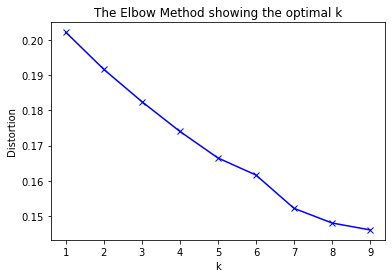

In [227]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(London_grouped_clustering)
    kmeanModel.fit(London_grouped_clustering)
    distortions.append(sum(np.min(cdist(London_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / London_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each PostCode.

In [228]:
# add clustering labels
PostCodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

London_merged = PrimOutsAreas_merged

# merge London_grouped with London_data to add latitude/longitude for each neighborhood
London_merged = London_merged.join(PostCodes_venues_sorted.set_index('PostCode'), on='PostCode')
London_merged = London_merged.drop(columns=['Type', 'Rating'])

London_merged # check the last columns!

,PostCode,Name,Location,Borough,Avg price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BR1,Burnt Ash Primary School,"Bromley,Plaistow,Sundridge,Widmore (also Widmo...",Bromley/Lewisham,537722.4,51.404240,0.015425,1,Pub,Clothing Store,Coffee Shop,Gym / Fitness Center,Park,Supermarket,Bar,Pizza Place,Burger Joint,Furniture / Home Store
1,BR3,"Clare House Primary School,Harris Primary Acad...","Beckenham,Bickley,Bromley Common,Eden Park,Elm...",Bromley,541131.6,51.415095,-0.035403,0,Grocery Store,Coffee Shop,Train Station,Pizza Place,Park,Bar,Tram Station,Mediterranean Restaurant,Tapas Restaurant,Bookstore
2,BR5,Crofton Junior School,"Ruxley,Upper Ruxley,Derry Downs,Orpington,Pett...",Bexley/Bromley,528127.2,51.388315,0.078482,0,Supermarket,Mediterranean Restaurant,Pub,Thai Restaurant,Sushi Restaurant,American Restaurant,Indian Restaurant,Coffee Shop,Turkish Restaurant,Fish & Chips Shop
3,CR0,"Chestnut Park Primary School,Harris Primary Ac...","Addington,Addiscombe,Coombe,Croydon,Forestdale...",Croydon/Sutton,414672.0,51.344980,-0.012265,0,Home Service,Tram Station,Convenience Store,Supermarket,Gas Station,Grocery Store,Cycle Studio,Entertainment Service,Food,Flower Shop
4,CR5,Woodcote Primary School,"Coulsdon,Old Coulsdon",Croydon,611338.8,51.300165,-0.123698,2,Fish & Chips Shop,Construction & Landscaping,Restaurant,Café,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
5,CR7,David Livingstone Academy,Thornton Heath,Croydon,409178.4,51.395663,-0.119445,0,Grocery Store,Hotel,Bus Stop,Supermarket,Auto Garage,Optical Shop,Coffee Shop,Fast Food Restaurant,Ethiopian Restaurant,Event Space
6,CR8,Beaumont Primary School,"Kenley,Purley,Riddlesdown",Croydon,532328.4,51.333275,-0.102381,0,Train Station,Platform,Cricket Ground,Breakfast Spot,Grocery Store,Pizza Place,Golf Course,Farmers Market,Entertainment Service,Ethiopian Restaurant
7,DA15,Burnt Oak Junior School,"Blackfen,Lamorbey,Longlands,Sidcup",Bexley,492000.0,51.463130,0.231270,3,Grocery Store,Hotel,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
8,DA16,Eastcote Primary Academy,"East Wickham,Falconwood,Welling",Bexley,486294.0,51.468977,0.117985,0,Supermarket,Coffee Shop,Pub,Gastropub,Grocery Store,Bakery,Gym / Fitness Center,Soccer Stadium,Chinese Restaurant,Pizza Place
9,E12,Essex Primary School,"Little Ilford,Manor Park",Newham,482749.2,51.514477,-0.058605,1,Coffee Shop,Hotel,Indian Restaurant,Pub,Grocery Store,Park,Pizza Place,Bar,Korean Restaurant,Bakery


Finally, let's visualize the resulting clusters

In [229]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged['Latitude'], London_merged['Longitude'], London_merged['PostCode'], London_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster. 

In [230]:
London_merged.loc[London_merged['Cluster Labels'] == 0, London_merged.columns[[0] + list(range(7, London_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,BR3,0,Grocery Store,Coffee Shop,Train Station,Pizza Place,Park,Bar,Tram Station,Mediterranean Restaurant,Tapas Restaurant,Bookstore
2,BR5,0,Supermarket,Mediterranean Restaurant,Pub,Thai Restaurant,Sushi Restaurant,American Restaurant,Indian Restaurant,Coffee Shop,Turkish Restaurant,Fish & Chips Shop
3,CR0,0,Home Service,Tram Station,Convenience Store,Supermarket,Gas Station,Grocery Store,Cycle Studio,Entertainment Service,Food,Flower Shop
5,CR7,0,Grocery Store,Hotel,Bus Stop,Supermarket,Auto Garage,Optical Shop,Coffee Shop,Fast Food Restaurant,Ethiopian Restaurant,Event Space
6,CR8,0,Train Station,Platform,Cricket Ground,Breakfast Spot,Grocery Store,Pizza Place,Golf Course,Farmers Market,Entertainment Service,Ethiopian Restaurant
8,DA16,0,Supermarket,Coffee Shop,Pub,Gastropub,Grocery Store,Bakery,Gym / Fitness Center,Soccer Stadium,Chinese Restaurant,Pizza Place
17,E6,0,Fast Food Restaurant,Pub,Grocery Store,Indian Restaurant,Sandwich Place,Park,Furniture / Home Store,Betting Shop,Electronics Store,Supermarket
20,HA0,0,Fast Food Restaurant,Indian Restaurant,Supermarket,Bar,Hotel,Gym / Fitness Center,Food & Drink Shop,Fish & Chips Shop,Soccer Field,Mediterranean Restaurant
21,HA1,0,Coffee Shop,Clothing Store,Indian Restaurant,Pizza Place,Sandwich Place,Convenience Store,Pharmacy,Fast Food Restaurant,Gym,Department Store
22,HA4,0,Supermarket,Gas Station,Pub,Pet Store,Café,Soccer Field,Shopping Plaza,Sandwich Place,Clothing Store,River


In [231]:
London_merged.loc[London_merged['Cluster Labels'] == 1, London_merged.columns[[0] + list(range(7, London_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BR1,1,Pub,Clothing Store,Coffee Shop,Gym / Fitness Center,Park,Supermarket,Bar,Pizza Place,Burger Joint,Furniture / Home Store
9,E12,1,Coffee Shop,Hotel,Indian Restaurant,Pub,Grocery Store,Park,Pizza Place,Bar,Korean Restaurant,Bakery
10,E13,1,Pub,Grocery Store,Hotel,Coffee Shop,Gym / Fitness Center,Sandwich Place,Park,Bakery,Café,Indian Restaurant
11,E14,1,Pub,Coffee Shop,Park,Grocery Store,Brewery,Pizza Place,Café,Gym / Fitness Center,Sandwich Place,Beer Bar
12,E15,1,Café,Coffee Shop,Pub,Indian Restaurant,Middle Eastern Restaurant,Flea Market,Hotel,Restaurant,Chocolate Shop,Art Gallery
13,E17,1,Hotel,Coffee Shop,Pub,Gym / Fitness Center,Middle Eastern Restaurant,Pizza Place,Art Gallery,Indian Restaurant,Cocktail Bar,French Restaurant
14,E1,1,Pub,Coffee Shop,Park,Café,Turkish Restaurant,Grocery Store,Hotel,Gym / Fitness Center,Bakery,Indian Restaurant
15,E2,1,Coffee Shop,Pub,Café,Restaurant,Cocktail Bar,Italian Restaurant,Yoga Studio,Wine Bar,Market,Bagel Shop
16,E5,1,Pub,Café,Coffee Shop,Grocery Store,Park,Turkish Restaurant,Pizza Place,Nature Preserve,Garden,Bus Stop
18,E8,1,Pub,Coffee Shop,Café,Brewery,Cocktail Bar,Bakery,Pizza Place,Flea Market,Beer Store,Vegetarian / Vegan Restaurant


In [232]:
London_merged.loc[London_merged['Cluster Labels'] == 2, London_merged.columns[[0] + list(range(7, London_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,CR5,2,Fish & Chips Shop,Construction & Landscaping,Restaurant,Café,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market


In [233]:
London_merged.loc[London_merged['Cluster Labels'] == 3, London_merged.columns[[0] + list(range(7, London_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,DA15,3,Grocery Store,Hotel,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm


In [234]:
London_merged.loc[London_merged['Cluster Labels'] == 4, London_merged.columns[[0] + list(range(7, London_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


Text(0.5, 1.0, 'Price bins')

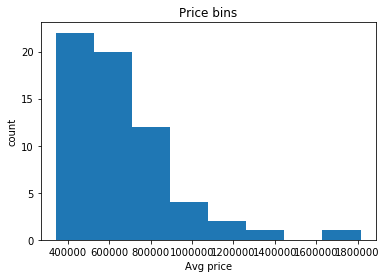

In [256]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(London_merged["Avg price"],bins=8)

# set x/y labels and plot title
plt.pyplot.xlabel("Avg price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price bins")

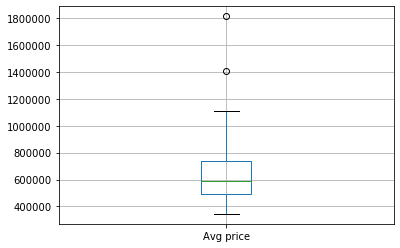

In [258]:
London_merged.boxplot(column='Avg price')

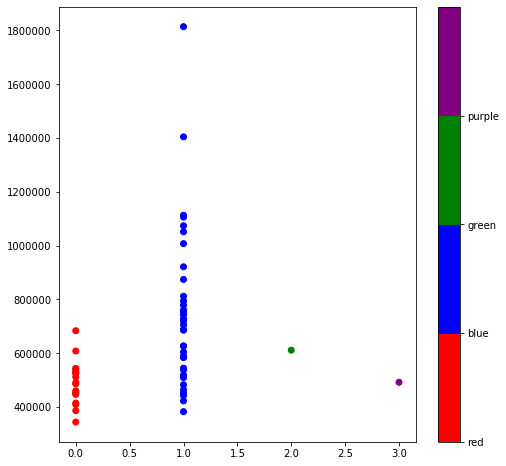

In [259]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
y = London_merged['Avg price']
x = London_merged['Cluster Labels']
colors = ['red','blue','green','purple']
label = London_merged['Cluster Labels']

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))


cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

End of the project